Dijkstra and Fast Marching Algorithms
=====================================
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


This notebook details the implementations
of Dijkstra and Fast Marching algorithms in 2-D.

Installation
------------
For this project, you only need `numpy` and `matplotlib`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Navigating on the Grid
----------------------
We use a cartesian grid of size $n \times n$, and defines operators to navigate in the grid.


We use a singe index $i \in \{1,\ldots,n^2\}$ to index a position on
the 2-D grid.


Size of the grid.

In [2]:
n = 100

The four displacement vector to go to the four neightbors.

In [3]:
neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])
print(neigh)

[[ 1 -1  0  0]
 [ 0  0  1 -1]]


For simplicity of implementation, we use periodic boundary conditions.

In [4]:
boundary = lambda x: np.mod(x,n)

For a given grid index |k|, and a given neighboring index k in ${1,2,3,4}$,
|Neigh(k,i)| gives the corresponding grid neighboring index.

In [5]:
ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
sub2ind1 = lambda u: int( u[0]*n + u[1] )
Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))

These functions are indeed bijections.

In [6]:
print( ind2sub1( sub2ind1([13, 27]) ) )
print( sub2ind1( ind2sub1(134) ) )

[13, 27]
134


Dikstra Algorithm
-----------------
The Dijkstra algorithm compute the geodesic distance on a graph.
We use here a graph whose nodes are the pixels, and whose edges defines the
usual 4-connectity relationship.


In the following, we use the notation $i \sim j$ to indicate that an
index $j$ is a neighbor of $i$ on the graph defined by the discrete
grid.


The metric $W(x)$. We use here a constant metric.

In [7]:
W = np.ones( (n,n) )

Set $\Ss = \{x_0\}$ of initial points.

In [8]:
x0 = [n/2, n/2]

Initialize the stack of available indexes.

In [9]:
I = [sub2ind1(x0)]

Initialize the distance to $+\infty$, excepted for the boundary conditions.

In [10]:
D = np.ones((n,n)) + np.inf
u = ind2sub1(I)
D[u[0],u[1]] = 0

Initialize the state to 0 (unexplored), excepted for the boundary point $\Ss$ (indexed by |I|)
to $1$ (front).

In [11]:
S = np.zeros((n,n))
S[u[0],u[1]] = 1

Define a callbabk to use a 1-D indexing on a 2-D array.

In [12]:
extract   = lambda x,I: x[I]
extract1d = lambda x,I: extract(x.flatten(),I)

The first step of each iteration of the method is
to pop the from stack the element $i$ with smallest current distance $D_i$.

In [13]:
j = np.argsort( extract1d(D,I)  )
if np.ndim(j)==0:
    j = [j]   # make sure that j is a list a not a singleton
j = j[0]
i = I[j]         
a = I.pop(j)

We update its state $S$ to be dead (-1).

In [14]:
u = ind2sub1(i);
S[u[0],u[1]] = -1

Retrieve the list of the neighbors that are not dead and add to I those that are not yet in it.

In [15]:
J = [] 
for k in np.arange(0,4):
    j = Neigh(i,k)
    if extract1d(S,j)!=-1:
        # add to the list of point to update
        J.append(j)           
        if extract1d(S,j)==0:
            # add to the front
            u = ind2sub1(j)
            I.append(j)
print("List of x_0 neighbors: ", I)

List of x_0 neighbors:  [5150, 4950, 5051, 5049]


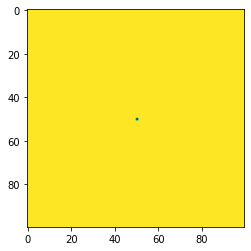

In [16]:
plt.figure()
plt.imshow(S)
plt.show()

Update neighbor values.
For each neightbo $j$ of $i$, perform the update,
assuming the length of the edge between $j$ and $k$ is $W_j$.
$$ D_j \leftarrow \umin{k \sim j} D_k + W_j. $$

In [17]:
DNeigh = lambda D,k: extract1d(D,Neigh(j,k))
for j in J:
    dx = min(DNeigh(D,0), DNeigh(D,1))
    dy = min(DNeigh(D,2), DNeigh(D,3))
    u = ind2sub1(j)
    w = extract1d(W,j);
    D[u[0],u[1]] = min(dx + w, dy + w)

## Dijkstra algorithm
We implement the Dijkstra algorithm by iterating these step while the
stack |I| is non empty.
Display from time to time the front that propagates.

In [18]:
n = 40
neigh = np.array([[1, -1, 0, 0], [0, 0,  1, -1]])
boundary = lambda x: np.mod(x,n)
ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
sub2ind1 = lambda u: int( u[0]*n + u[1] )
Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))
extract   = lambda x,I: x[I]
extract1d = lambda x,I: extract(x.flatten(),I)

In [19]:
def init(x0 = [n/2, n/2], W = np.ones( (n,n) ) ):
    I = [sub2ind1(x0)]
    D = np.ones( (n,n) ) + np.inf
    u = ind2sub1(I)
    D[u[0],u[1]] = 0
    S = np.zeros( (n,n) )
    S[u[0],u[1]] = 1
    
    return [W, D, S, I]

def classic_step(W, D, S, I):
    j = np.argsort(extract1d(D, I))
    if len(j) == 0:
        end = True
        return D,S,I, [], end
    j = j[0]
    i = I.pop(j)
    u = ind2sub1(i);
    S[u[0], u[1]] = -1
    J = []
    for k in np.arange(0, 4):
        j = Neigh(i, k)
        if extract1d(S, j) != -1:
            # add to the list of point to update
            J.append(j)
            if extract1d(S, j) == 0:
                # add to the front
                u = ind2sub1(j)
                S[u[0], u[1]] = 1
                I.append(j)
    return [np.copy(D), np.copy(S), I, J, False]



In [20]:
def update_D_norme1(W, D, J):
    #Update distance by looking at all available places
    for j in J:
        DNeigh = lambda D, k: extract1d(D, Neigh(j, k))
        dx = min(DNeigh(D,0), DNeigh(D,1))
        dy = min(DNeigh(D,2), DNeigh(D,3))
        u = ind2sub1(j)
        w = extract1d(W,j);
        D[u[0],u[1]] = min(dx + w, dy + w)
    return D

In [21]:
def dijkstra(update_norme, step, x0 = [n/2, n/2], W = np.ones( (n,n) ) ):
    [W, D, S, I] = init(x0, W)
    iteration = 0
    J = []
    end = False
    while True:
        [D, S, I, J, end] = step(W, D, S, I)
        if end:
            break
        else:
            D = update_norme(W, D, J)

        # iteration update
        if iteration % 400 == 0:
            plt.figure()
            plt.imshow(D)
            plt.set_cmap('jet')
            plt.show()
        iteration += 1
        start = False
    plt.figure(1)
    plt.imshow(D)
    plt.show()
    return D

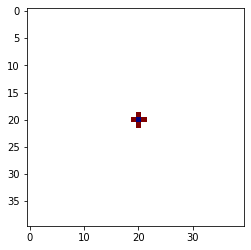

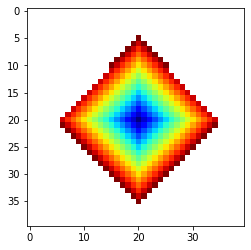

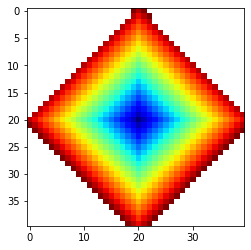

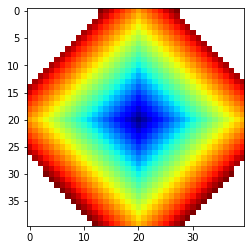

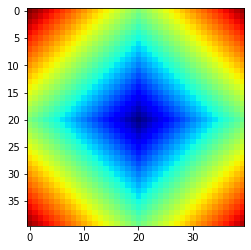

In [22]:
D_norme1 = dijkstra(update_D_norme1, classic_step)

We display the geodesic distance map using a cosine modulation to make the
level set appears more clearly.

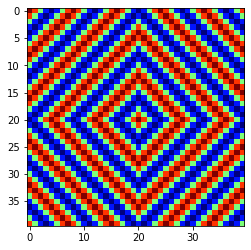

In [23]:
displ = lambda D: np.cos(2*np.pi*5*D/max(D.flatten()) )
plt.imshow(displ(D_norme1))
plt.set_cmap('jet')

Fast Marching
-------------
The Dijstra algorithm suffers from a strong metrization problem, and it
actually computes the $\ell^1$ distance on the grid.


The Fast Marching algorithm replace the graph update by a local
resolution of the Eikonal equation. This reduces significantly the grid
bias, and can be shown to converge to the underlying geodesic distance
when the grid step size tends to zero.


Over a continuous domain, the distance map $D(x)$ to a set of seed
points $ \Ss $ is the unique solution in the viscosity sense
$$ \forall x \notin \Ss, \quad \norm{\nabla D(x)} = W(x)
      \qandq
    \forall y \in \Ss, \quad D(y) = 0. $$


The equation is then discretized on a grid of $n \times n$ pixel, and a
solution $ (D_{k,\ell})_{k,\ell=1}^n \in \RR^{n \times n} $ is found by using
an upwind finite difference approximation, that is faithful to the
viscosity solution
$$ \forall (k,\ell) \notin \tilde \Ss,  \quad
     \norm{ (\nabla D)_{k,\ell} } = W_{k,\ell}$
  \qandq
  \forall (k,\ell) \notin \tilde \Ss, \quad D_{k,\ell}=0,
$$
where $\tilde \Ss$ is the set of discrete starting points (defined here
by |x0|).


To be consisten with the viscosity solution, one needs to use a
non-linear upwind gradient derivative. This corresponds to computing
the norm of the gradient as
$$ \norm{ (\nabla D)_{k,\ell} }^2 =
      \max( D_{k+1,\ell}-D_{k,\ell}, D_{k-1,\ell}-D_{k,\ell}, 0 )^2 +
      \max( D_{k,\ell+1}-D_{k,\ell}, D_{k,\ell-1}-D_{k,\ell}, 0 )^2.
$$


A each step of the FM propagation, one update $ D_{k,\ell} \leftarrow d $
by solving the eikonal equation with respect to $D_{k,\ell}$ alone.
This is equivalent to solving the quadratic equation
$$ (d-d_x)^2 + (d-d_y)^2 = w^2 \qwhereq w=W_{k,\ell}. $$
and where
$$ d_x = \min(D_{k+1,\ell},D_{k-1,\ell}) \qandq
   d_y = \min(D_{k,\ell+1},D_{k,\ell-1}). $$


The update is thus defined as
$$
      d = \choice{
          \frac{d_x+d_y+ \sqrt{\De}}{2} \quad\text{when}\quad \De \geq 0, \\
          \min(d_x,d_y)+w \quad \text{otherwise.}$
      }$
      \qwhereq
      \De = 2 w^2 - (d_x-d_y)^2.
$$


Note that in the case where $\De<0$, one has to use the Dijkstra
update.


Once the Dijstra algorithm is implemented, the implementation of the Fast
Marching is trivial. It just corresponds to replacing the graph udpate by the eikonal update.

In [24]:
def update_D_norme2(W, D, J):
    for j in J:
        DNeigh = lambda D, k: extract1d(D, Neigh(j, k))
        dx = min(DNeigh(D, 0), DNeigh(D, 1))
        dy = min(DNeigh(D, 2), DNeigh(D, 3))
        u = ind2sub1(j)
        w = extract1d(W, j)
        Delta = 2 * w ** 2 - (dx - dy) ** 2
        if (Delta >= 0):
            D[u[0], u[1]] = (dx + dy + np.sqrt(Delta)) / 2
        else:
            D[u[0], u[1]] = min(dx + w, dy + w)
    return D

We implement the Fast Marching algorithm and display from time to time the front that propagates.

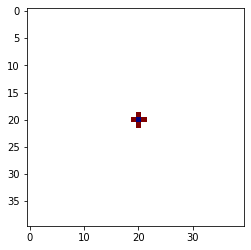

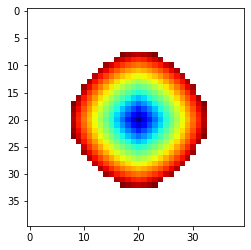

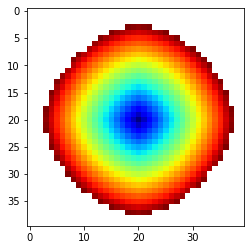

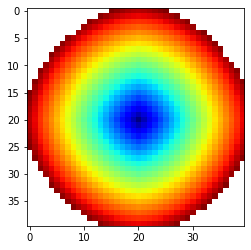

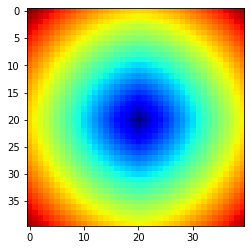

In [25]:
D_norme2 = dijkstra(update_D_norme2, classic_step,)

We display the geodesic distance map using a cosine modulation to make the
level set appears more clearly.

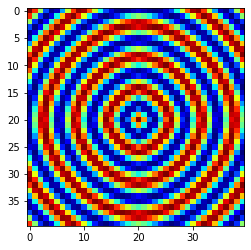

In [26]:
displ = lambda D: np.cos(2*np.pi*5*D/max(D.flatten()) )
plt.imshow(displ(D_norme2))
plt.set_cmap('jet')

Computation of Geodesic Paths
-----------------------------
We use a more complicated, non-constant metric, with a bump in the
middle.

In [27]:
n = 100
x = np.linspace(-1, 1, n)
[Y, X] = np.meshgrid(x, x)
sigma = .2
W = 1 + 8 * np.exp(-(X**2 + Y**2)/ (2*sigma**2))

We display it.

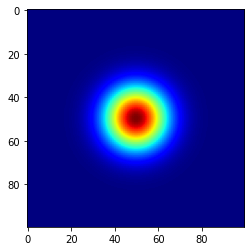

In [28]:
plt.imshow(W)
plt.show()

Starting points.

In [29]:
x0 = [round(.1*n), round(.1*n)]

We compute the distance map to these starting point using the FM algorithm. _Important:_ The time, we control that our map is not periodic

In [30]:
def boundaries_control(x):
    inside_boundary = ((x[0])//n == 0) and ((x[1])//n == 0)
    return np.mod(x,n), inside_boundary


def newNeigh(pixel_initial,i):
    neighbor, inside_boundary = boundaries_control(ind2sub1(pixel_initial) + neigh[:,i])
    return sub2ind1(neighbor), inside_boundary


def newDNeigh(D,k, j):
    n, b = newNeigh(j,k)
    if b==False:
        return np.inf
    else:
        return extract1d(D,n)

def update_D_norme2_with_boundaries(W, D, J):
    for j in J:
        n1 = newDNeigh(D, 0, j)
        n2 = newDNeigh(D, 1, j)
        n3 = newDNeigh(D, 2, j)
        n4 = newDNeigh(D, 3, j)
        dx = min(n1, n2)
        dy = min(n3, n4)
        u = ind2sub1(j)
        w = extract1d(W, j)
        Delta = 2 * w ** 2 - (dx - dy) ** 2
        if (Delta >= 0):
            D[u[0], u[1]] = (dx + dy + np.sqrt(Delta)) / 2
        else:
            D[u[0], u[1]] = min(dx + w, dy + w)
    return D

def step_with_boundaries(W, D, S, I):
    j = np.argsort(extract1d(D, I))
    if len(j) == 0:
        end = True
        return D,S,I, [], end
    j = j[0]
    i = I.pop(j)
    u = ind2sub1(i);
    S[u[0], u[1]] = -1
    J = []
    for k in np.arange(0, 4):
        j, inside_boundary = newNeigh(i, k)
        if inside_boundary:
            if extract1d(S, j) != -1:
                # add to the list of point to update
                J.append(j)
                if extract1d(S, j) == 0:
                    # add to the front
                    u = ind2sub1(j)
                    S[u[0], u[1]] = 1
                    I.append(j)
    return [np.copy(D), np.copy(S), I, J, False]

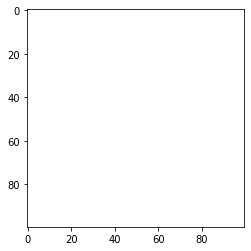

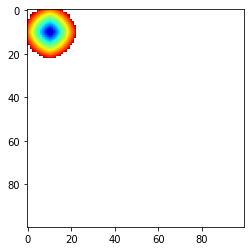

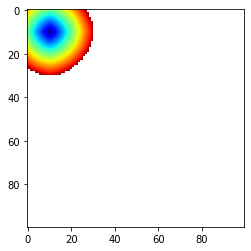

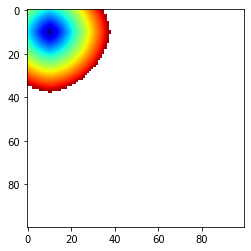

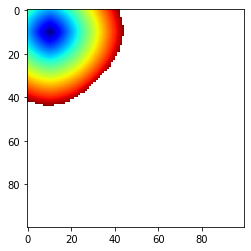

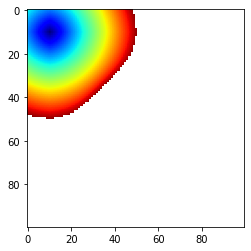

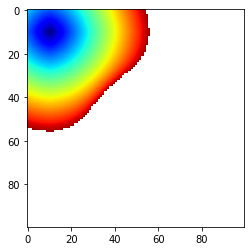

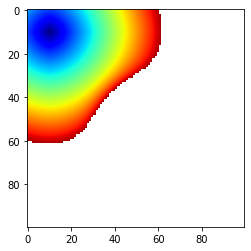

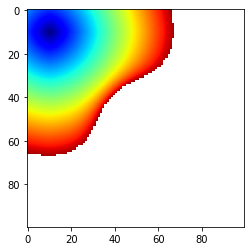

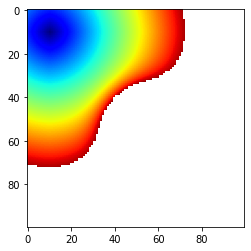

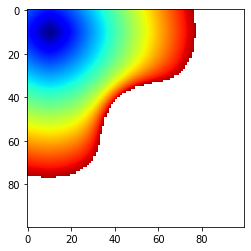

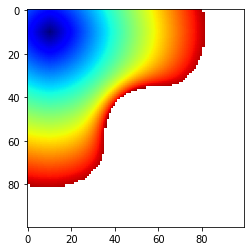

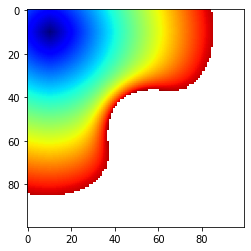

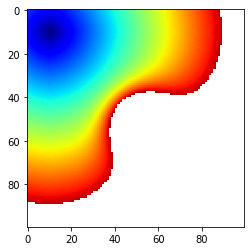

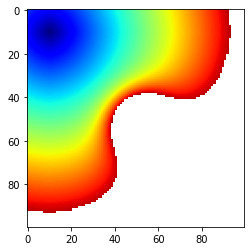

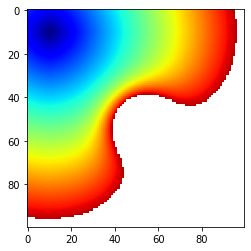

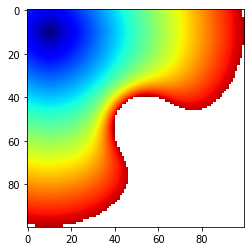

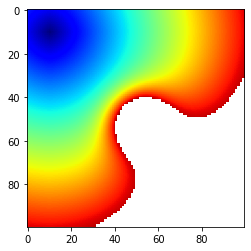

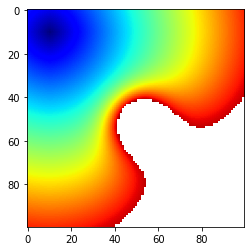

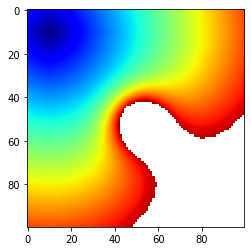

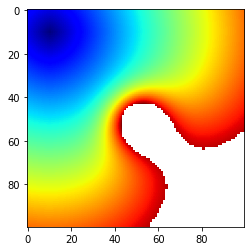

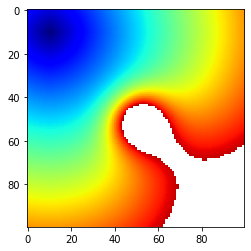

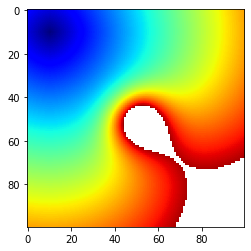

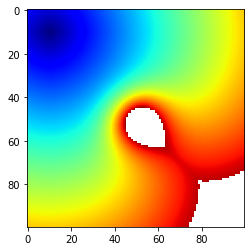

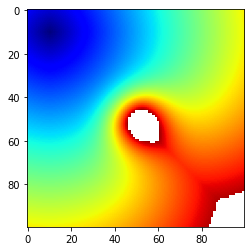

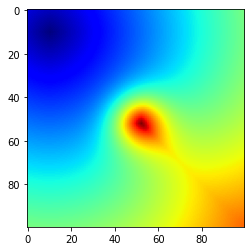

In [31]:
# compteur = 0
D_geodesic = dijkstra(update_D_norme2_with_boundaries, step_with_boundaries,  x0, W)

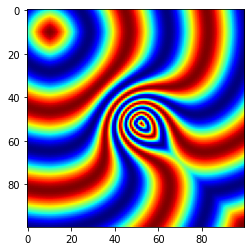

In [32]:
# D_geodesic[0,0] = 0  #LIGNE DE VANDALE (je ne sais pas pourquoi, mais mon Dijkstra a un problème en [0,0])
displ = lambda D: np.cos(2*np.pi*5*D/max(D_geodesic.flatten()) )
plt.imshow(displ(D_geodesic))
plt.set_cmap('jet')

Once the geodesic distance map to $\Ss$
has been computed, the geodesic curve between any point $x_1$ and $\Ss$
extracted through gradient descent
$$ \ga'(t) = - \eta_t \nabla D(\ga(t)) \qandq \ga(0)=x_1 $$
where $\eta_t>0$ controls the parameterization speed of the resulting
curve.


To obtain unit speed parameterization, one can use $\eta_t =
\norm{\nabla D(\ga(t))}^{-1}$ (one need to be careful when
$\ga$ approaches $\Ss$ since $D$ is not smooth on $\Ss$).


We compute the gradient $G_0(x) = \nabla D(x) \in \RR^2$ of the distance map.

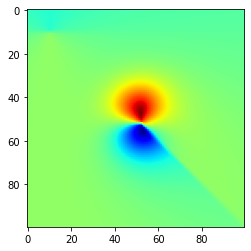

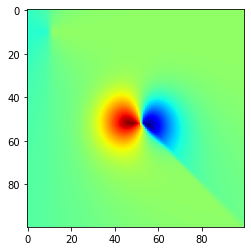

In [33]:
G0 = np.gradient(D_geodesic)
# print(G0)
plt.figure()
plt.imshow(G0[0])
plt.show()

plt.figure()
plt.imshow(G0[1])
plt.show()

We normalize the gradient to obtained $G(x) = G_0(x)/\norm{G_0(x)}$, in order to have unit speed geodesic curve (parameterized
by arc length).

In [34]:
d = np.sqrt(np.sum(np.array(G0)**2, axis=0))
U = np.zeros((2,n,n))
U[0,:,:] = d
U[1,:,:] = d
G0 = np.array(G0)
G = G0 / U

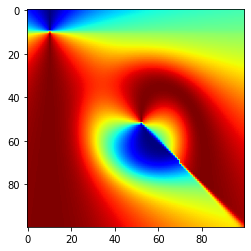

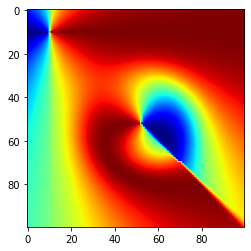

In [35]:
plt.figure()
plt.imshow(G[0,:,:])
plt.show()


plt.figure()
plt.imshow(G[1,:,:])
plt.show()

The geodesic is then numerically computed using a discretized gradient
descent, which defines a discret curve $ (\ga_k)_k $ using
$$ \ga_{k+1} = \ga_k - \tau G(\ga_k) $$
where $\ga_k \in \RR^2$ is an approximation of $\ga(t)$ at time
$t=k\tau$, and the step size $\tau>0$ should be small enough.


Step size $\tau$ for the gradient descent.

In [36]:
tau = .8

We initialize the path with the ending point.

In [37]:
x1 = np.array([round(.9*n), round(.88*n)])
gamma = [x1]

We define a shortcut to interpolate $G$ at a 2-D points.

In [38]:
def Geval(X, G):
    x, y = X
    xinf = np.int(x)
    xsup = xinf + 1
    yinf = np.int(y)
    ysup = yinf + 1
    
    return (G[:, xinf, yinf] * (xsup - x) * (ysup - y) +
            G[:, xinf, ysup] * (xsup - x) * (y - yinf) +
            G[:, xsup, yinf] * (x - xinf) * (ysup - y) +
            G[:, xsup, ysup] * (x - xinf) * (y - yinf) )

We compute the gradient at the last point in the path, using interpolation.

In [39]:
g = Geval(gamma[-1], G)

C:\Users\alexa\AppData\Local\Temp\ipykernel_128756\3933966707.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xinf = np.int(x)
C:\Users\alexa\AppData\Local\Temp\ipykernel_128756\3933966707.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additio

Perform the descent and add the new point to the path.

In [40]:
gamma.append( gamma[-1] - tau*g )

## Shortest path algorithm

We perform the full geodesic path extraction by iterating the gradient
descent. One must be very careful when the path become close to
$x_0$, because the distance function is not differentiable at this
point. We must stop the iteration when the path is close to $x_0$.

In [41]:
while np.linalg.norm(gamma[-1] - x0) / np.linalg.norm(x0) > 0.05:
    g = Geval(gamma[-1], G)
    gamma.append( gamma[-1] - tau*g )

C:\Users\alexa\AppData\Local\Temp\ipykernel_128756\3933966707.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xinf = np.int(x)
C:\Users\alexa\AppData\Local\Temp\ipykernel_128756\3933966707.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additio

Display the geodesic curve.

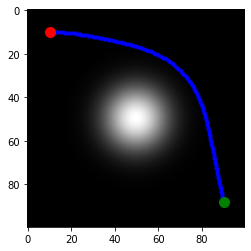

In [42]:
plt.figure()
plt.imshow(W) 
plt.set_cmap('gray')
h = plt.plot(np.array(gamma)[:,0], np.array(gamma)[:,1], '.b', linewidth=2)
h = plt.plot(x0[1], x0[0], '.r', markersize=20)
h = plt.plot(x1[0], x1[1], '.g', markersize=20)

# Exemple jouet: Routes de France

In [43]:
# Import your Image
from PIL import Image
image_france = Image.open("carte_france_relief.jpg")
carte_france = np.array(image_france)

In [44]:
#Select your pixels of interest

# Paris
x0 = np.array([55,25])
# Nice
x1 = np.array([87, 78])
# Montpellier
x2 = np.array([62,80])
# Toulouse
x3 = np.array([40,80])
# Brest
x4 = np.array([1, 28])
# Strasbourg
x5 = np.array([87,25])
# Bordeaux
x6 = np.array([25,62])
# Lille
x7 = np.array([55,5])

cities = ["Nice", "Montpellier", "Toulouse", "Brest", "Strasbourg", "Bordeaux", "Lille"]

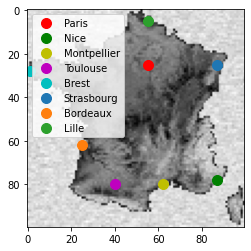

In [45]:
# In[74]:
carte_france.shape
n = 100
W = carte_france[:,:,0] + np.random.normal(0,1)**2
plt.imshow(W)
plt.set_cmap('gray')
plt.plot(x0[0], x0[1], '.r', markersize=20, label = "Paris")
plt.plot(x1[0], x1[1], '.g', markersize=20, label = "Nice")
plt.plot(x2[0], x2[1], '.y', markersize=20, label="Montpellier")
plt.plot(x3[0], x3[1], '.m', markersize=20, label="Toulouse")
plt.plot(x4[0], x4[1], '.c', markersize=20, label="Brest")
plt.plot(x5[0], x5[1], '.', markersize=20, label="Strasbourg")
plt.plot(x6[0], x6[1], '.', markersize=20, label="Bordeaux")
plt.plot(x7[0], x7[1], '.', markersize=20, label="Lille")
plt.legend()
plt.show()
X = np.array([x1,x2,x3,x4,x5,x6,x7])
# W = np.concatenate((255*np.ones((7,W.shape[1])), W), axis=0)
D = np.full(W.shape, np.infty)
S = np.zeros(W.shape)

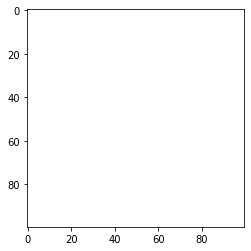

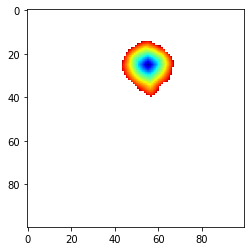

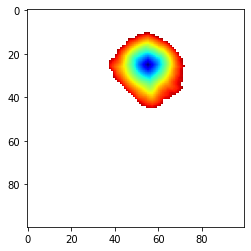

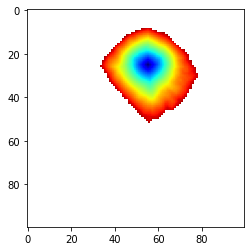

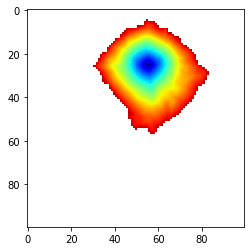

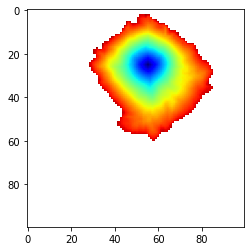

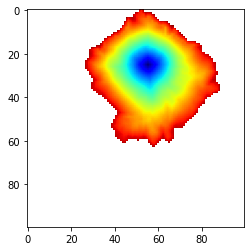

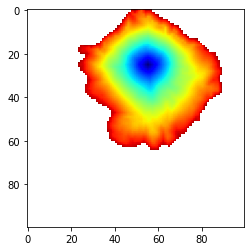

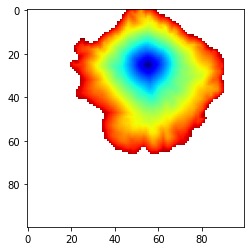

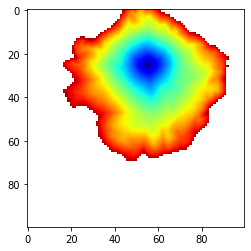

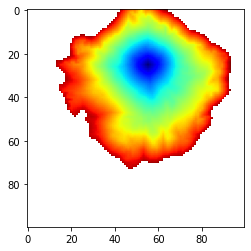

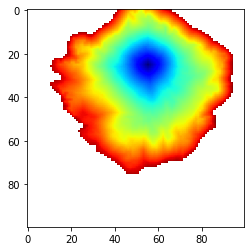

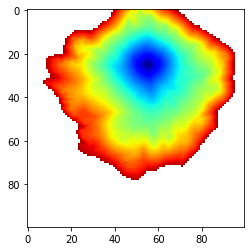

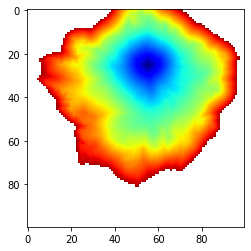

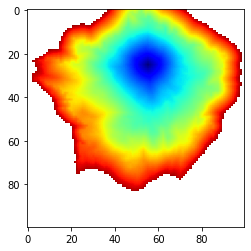

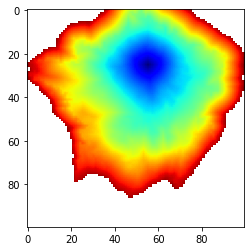

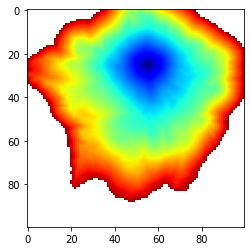

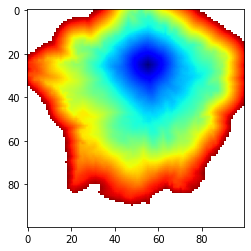

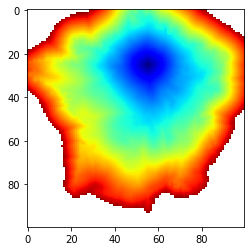

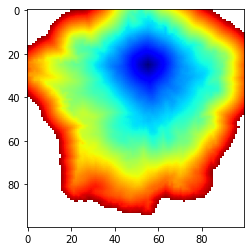

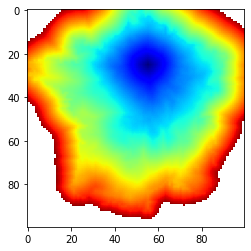

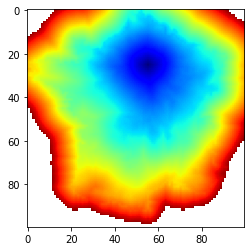

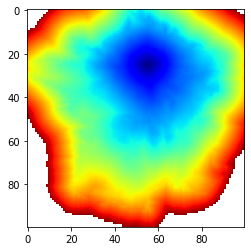

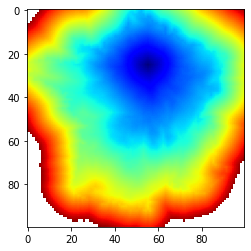

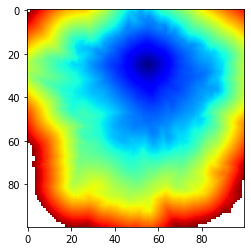

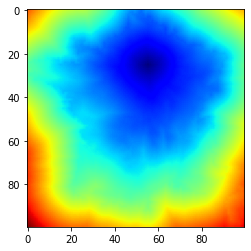

In [46]:
D_france = dijkstra(update_D_norme2_with_boundaries, step_with_boundaries, [x0[1],x0[0]], W)

In [47]:
# Create a function to use the Distance map and find the 
def plus_court_chemin(x_0, x0_label, X, X_labels, Distance_map):
    # Compute the gradient of the distance map
    G0 = np.gradient(Distance_map.T)
    d = np.sqrt(np.sum(np.array(G0)**2, axis=0))
    U = np.zeros((2,n,n))
    U[0,:,:] = d+10
    U[1,:,:] = d+10
    G0 = np.array(G0)
    G = G0 / U
    
    # For each city, use the optimization algorithm to determine the 
    nb_ville = 0
    h = plt.figure()
    h = plt.plot(x0[0], x0[1], '.', markersize=20, label=x0_label)
    for x1 in X:
        #Start the optimization loop
        city = X_labels[nb_ville]
        nb_ville += 1
        gamma = [x1]
        tau = 0.1
        itermax = 100000
        niter = 0
        while np.linalg.norm(gamma[-1] - x0) / np.linalg.norm(x0) > 0.05 and niter < itermax:
            g = Geval(gamma[-1], G)
            gamma.append( gamma[-1] - tau*g )
            niter += 1
            
        # Plot the computed trajectories
        W_plus = np.ones((W.shape[0], W.shape[1]+50)) * 255
        W_plus[:W.shape[0], :W.shape[1]] = np.copy(W)
        plt.imshow(W_plus) 
        plt.set_cmap('gray')
        h = plt.plot(np.array(gamma)[:,0], np.array(gamma)[:,1], '.b', linewidth=2)
        h = plt.plot(x1[0], x1[1], '.', markersize=20, label=city)
    h = plt.legend()
    h = plt.plot()


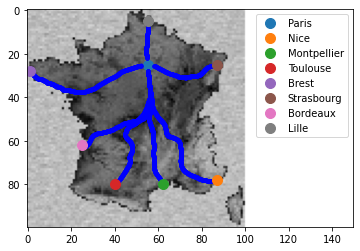

In [48]:
import warnings
warnings.filterwarnings('ignore')
plus_court_chemin(x0, "Paris",  X, cities,  D_france)